In [1]:
from helpers import *

def od_xml_to_df(file_path):

    tree = ET.parse(file_path)
    root = tree.getroot()
    gt_od_df =  xml2df_str(root, 'tazRelation')
    
    gt_od_vals = gt_od_df['count'].astype(float)
    print('total GT demand: ',gt_od_vals.sum())

    return gt_od_df

In [2]:
base_path = '/Users/rodrse/Downloads/ForSergio_nov26_2023_final'

In [3]:

taz2edge_xml = 'taz_new.xml'
net_xml = 'SFO.net.xml'
fixed_routes_xml = f'{base_path}/5hr_route_choice_set.csv'
od_duration_seconds = 5*60 

# duration of sample time for simulation output statistics
simulation_stat_freq_sec = od_duration_seconds
sim_end_time = od_duration_seconds
additional_xml = f'additional.add_statfreq{od_duration_seconds}.xml'

# suffix of simulation output edge file
EDGE_OUT_STR = 'edge_data_SFO.xml'
TRIPS2ODS_OUT_STR = 'trips.xml'
SUMO_PATH = '/usr/local/opt/sumo/share/sumo'

In [4]:
gt_version_str = 'v4'

# gt v4:
mean_od_val = 100
num_ods = 10

print('if you want to optimize them all (~86k) set num_ods as defined in commented line below')
#num_ods = routes_df.shape[0]

if you want to optimize them all (~86k) set num_ods as defined in commented line below


In [5]:
od_xml = f'gt_od_{gt_version_str}.xml'
file_gt = f'{base_path}/gt_od_{gt_version_str}.xml'
file_gt_edges = f'{base_path}/gt_edges_{gt_version_str}.csv'
prefix_output_gt = f'gt_{gt_version_str}'

In [6]:
# Get GT OD
print("Reading:",file_gt)
tree = ET.parse(file_gt)
root = tree.getroot()
gt_od_df =  xml2df_str(root, 'tazRelation')

gt_od_df.head()

Reading: /Users/rodrse/Downloads/ForSergio_nov26_2023_final/gt_od_v4.xml


,from,to,count,data
0,10100,10400,97.4,None
1,10100,10500,114.9,None
2,10100,105000,104.1,None
3,10100,108100,100.0,None
4,10100,108200,109.1,None


In [7]:
print("Reading:",fixed_routes_xml)
routes_df = pd.read_csv(fixed_routes_xml, index_col=0)

Reading: /Users/rodrse/Downloads/ForSergio_nov26_2023_final/5hr_route_choice_set.csv


In [8]:
gt_od_df = od_xml_to_df(file_gt)

total GT demand:  1044.3999999999999


In [9]:
gt_od_df.columns

Index(['from', 'to', 'count', 'data'], dtype='object')

## High-Dimensional sample-efficient Bayesian Optimization 

Source: https://botorch.org/tutorials/saasbo

### Declare parameter space

In [10]:
import torch

device = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")
dtype = torch.double

### Declare search space
# dimensionality of input space

dim_od = gt_od_df.shape[0]

#bounds = torch.tensor([
#    [ gt_od_df['count'].astype(float).min() - 2 for _ in range(dim_od)],
#    [ gt_od_df['count'].astype(float).max() + 2 for _ in range(dim_od)]
#], device=device, dtype=dtype) 

bounds = torch.tensor([
    [ 0 for _ in range(dim_od)],
    [ 2000 for _ in range(dim_od)]
], device=device, dtype=dtype) 


bounds



tensor([[   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.],
        [2000., 2000., 2000., 2000., 2000., 2000., 2000., 2000., 2000., 2000.]],
       dtype=torch.float64)

In [11]:
gt_od_df['count'].astype(float).min()

87.8

In [13]:
gt_od_df['count'].astype(float).max()

114.9

Read output of GT simulation

In [14]:

sim_edge_out_gt = f'{base_path}/{prefix_output_gt}_{EDGE_OUT_STR}'
df_edge_gt, _, _ = parse_loop_data_xml_to_pandas(base_path, sim_edge_out_gt, prefix_output_gt,SUMO_PATH)
# picking at edges as GT edges
num_gt_edges = df_edge_gt.shape[0]
print("Number of GT edges:",num_gt_edges)
gt_edge_data = df_edge_gt\
    .sort_values(by=['interval_nVehContrib'], ascending=False)\
    .iloc[:num_gt_edges]

#gt_edge_data.shape




Number of GT edges: 197


#### Bayesian optimization helpers

In [15]:
from botorch import fit_fully_bayesian_model_nuts
from botorch.acquisition import qExpectedImprovement
from botorch.models.fully_bayesian import SaasFullyBayesianSingleTaskGP
from botorch.models.transforms import Standardize
from botorch.models.transforms import Standardize
from botorch.utils.transforms import normalize


In [16]:
WARMUP_STEPS = 32
NUM_SAMPLES = 16
THINNING = 16

In [17]:
from botorch.optim import optimize_acqf
from botorch.utils.transforms import unnormalize


def optimize_acqf_and_get_observation(acq_func,bounds):
    """Optimizes the acquisition function, and returns a new candidate."""
    
    dim = acq_func.model.train_inputs[0].size(dim=1)

    # optimize
    candidates, _ = optimize_acqf(
        acq_function=acq_func,
        bounds=torch.tensor([[0.0] * dim, [1.0] * dim], device=device, dtype=dtype),
        q=BATCH_SIZE,
        num_restarts=NUM_RESTARTS,
        raw_samples=RAW_SAMPLES,  # used for intialization heuristic
    )

    # observe new values 
    new_x = candidates.detach()
    
    return unnormalize(new_x, bounds)

In [18]:

df_0 = pd.read_csv(base_path + f"/initial_search/data_set_ods_0_2000.csv")

In [19]:

NITER = 250
BATCH_SIZE = 1 
NUM_RESTARTS = 10
RAW_SAMPLES = 1024
    

In [22]:
#/Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/vanilla_bo
### Run loop
dim=dim_od


# Data frame of current training data
df_training = df_0
df_training["bo_iteration"] = 0

#num_epsilon_iter = 2
bayes_opt_method = "bayesian_optimization/saasbo_experiment_2"
ods_epsilon = []
loss_all = []
batch_data_i = []


In [23]:

# Base OD which we will update their count entries
base_od = gt_od_df.copy()
gt_od_vals = gt_od_df['count'].astype(float).to_numpy()

best_value = []
print(f"###### Total number of BO iterations: {NITER} ########################")
for i in range(NITER):

    file_od_epsilon_xml = f'{bayes_opt_method}/gt_od_{gt_version_str}_{i}.xml'
    prefix_output = f'{bayes_opt_method}/bayesOpt_{i}'


    ########
    # Start BO step
    ########

    print(f"########### BO iteration={i+1} ###########")

    # Obtain sampling locations x
    train_X = torch.from_numpy(
        df_training[[col for col in df_training.columns if "x" in col]].values
    )    

    # Normalize
    train_X_norm = normalize(train_X,bounds)

    # Obtain reponse data
    train_Y = -torch.from_numpy(df_training[["loss"]].values) # Take negative

    ###
    #Obtain next sampling location given current training data
    ###

    # best value so far
    best_y = train_Y.max()
    best_value.append(best_y)
    print(f"##### best_value={best_y} #####")

    # Declare model with newest data
    gp = SaasFullyBayesianSingleTaskGP(
        train_X=train_X_norm,
        train_Y=train_Y,
        outcome_transform=Standardize(m=1),
    )

    # Fit model
    print("Fitting GP model...")
    fit_fully_bayesian_model_nuts(
        gp,
        warmup_steps=WARMUP_STEPS,
        num_samples=NUM_SAMPLES,
        thinning=THINNING,
        disable_progbar=True,
    )

    # Computing the median lengthscales over the MCMC dimensions 
    # makes it clear that the first feature has the smallest lengthscale
    print("Median lengthscales over the MCMC dimensions")
    print(gp.median_lengthscale.detach())    

    # Construct acquistion function 
    EI = qExpectedImprovement(model=gp, best_f=best_y)
    
    # Maximize acquisition function to get next observation
    print("Optimizing acquisition function...")
    x_i = optimize_acqf_and_get_observation(acq_func=EI,bounds=bounds)
    x_i = x_i.cpu().detach().numpy()

    ########
    # End BO step
    ########    


    # Sample simulator (inner loop across all sampling locations within a batch)
    # TODO: Parallelize
    batch_data_i = []
    for j in range(BATCH_SIZE):
        loss_all = []
        print(f"########### Sampling location={j+1} ###########")

        # Generate OD
        #curr_od = gt_od_vals.copy()
        curr_od = x_i[j]

        print(f'total expected GT demand: {np.sum(curr_od)}')

        base_od['count'] = curr_od
        # round to 1 decimal point
        base_od['count'] = [round(elem, 1) for elem in base_od['count']]     
        base_od = base_od.rename(columns={'fromTaz':'from', 'toTaz':'to'})        
        create_taz_xml(file_od_epsilon_xml, base_od, od_duration_seconds, base_path)

        # simulate gt od
        simulate_od(file_od_epsilon_xml, 
                    prefix_output, 
                    base_path, 
                    net_xml, 
                    taz2edge_xml, 
                    additional_xml, 
                    routes_df,
                    sim_end_time,
                    TRIPS2ODS_OUT_STR)

        ## Compute loss
        sim_edge_out = f'{base_path}/{prefix_output}_{EDGE_OUT_STR}'
        print(sim_edge_out)
        curr_loop_stats, _, _ = parse_loop_data_xml_to_pandas(base_path, sim_edge_out,prefix_output,SUMO_PATH)
        curr_loss = compute_nrmse_counts_all_edges(gt_edge_data, curr_loop_stats)

        loss_all.append(curr_loss)
        print(f"############## loss: {curr_loss} ##############")

        # Parse training data
        df_j = pd.DataFrame(x_i[j].reshape(1,dim_od),
                            columns = [f"x_{i+1}" for i in range(dim_od)])
        df_j['loss'] = curr_loss
        batch_data_i.append(df_j)

    df_i = pd.concat(batch_data_i)
    df_i["bo_iteration"] = i+1

    df_training = pd.concat([df_training,df_i])


###### Total number of BO iterations: 250 ########################
########### BO iteration=1 ###########
##### best_value=-0.2430874984699992 #####
Fitting GP model...
Median lengthscales over the MCMC dimensions
tensor([2.0117, 0.3848, 6.1543, 3.6780, 1.3835, 9.1404, 8.1588, 2.2070, 4.9533,
        2.7447], dtype=torch.float64)
Optimizing acquisition function...
########### Sampling location=1 ###########
total expected GT demand: 8689.86469313949
Created  /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/saasbo_experiment_2/gt_od_v4_0.xml
od2trips  --spread.uniform --taz-files /Users/rodrse/Downloads/ForSergio_nov26_2023_final/taz_new.xml --tazrelation-files /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/saasbo_experiment_2/gt_od_v4_0.xml -o /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/saasbo_experiment_2/bayesOpt_0_trips_beforeRteUpdates.xml
Success.time 298.96
###### Running SUMO #######
Seed 0
sumo --out

/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/botorch/models/fully_bayesian.py:124: RuntimeWarning: Received a linear algebra error while sampling with Pyro. Adding a jitter of 1e-08 to the covariance matrix and retrying.
  warnings.warn(
/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/botorch/models/fully_bayesian.py:124: RuntimeWarning: Received a linear algebra error while sampling with Pyro. Adding a jitter of 1e-07 to the covariance matrix and retrying.
  warnings.warn(
/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/botorch/models/fully_bayesian.py:124: RuntimeWarning: Received a linear algebra error while sampling with Pyro. Adding a jitter of 9.999999999999999e-06 to the covariance matrix and retrying.
  warnings.warn(
/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/botorch/models/fully_bayesian.py:124: RuntimeWarning: Received a linear algebra error while sampling with Pyro. Adding a jitter of 0.009999999999

Median lengthscales over the MCMC dimensions
tensor([0.0350, 0.8386, 1.1671, 0.7945, 2.3291, 0.7431, 1.7343, 0.8926, 2.1239,
        0.3441], dtype=torch.float64)
Optimizing acquisition function...
########### Sampling location=1 ###########
total expected GT demand: 8724.400875228317
Created  /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/saasbo_experiment_2/gt_od_v4_12.xml
od2trips  --spread.uniform --taz-files /Users/rodrse/Downloads/ForSergio_nov26_2023_final/taz_new.xml --tazrelation-files /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/saasbo_experiment_2/gt_od_v4_12.xml -o /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/saasbo_experiment_2/bayesOpt_12_trips_beforeRteUpdates.xml
Success.time 299.74
###### Running SUMO #######
Seed 0
sumo --output-prefix bayesian_optimization/saasbo_experiment_2/bayesOpt_12_ --ignore-route-errors=true --net-file=/Users/rodrse/Downloads/ForSergio_nov26_2023_final/SFO.net.xm

/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/botorch/models/fully_bayesian.py:124: RuntimeWarning: Received a linear algebra error while sampling with Pyro. Adding a jitter of 1e-08 to the covariance matrix and retrying.
  warnings.warn(


Median lengthscales over the MCMC dimensions
tensor([0.0422, 0.8630, 0.4836, 1.5126, 1.4600, 0.4398, 2.9354, 1.3211, 1.7206,
        2.5747], dtype=torch.float64)
Optimizing acquisition function...
########### Sampling location=1 ###########
total expected GT demand: 8784.64681337282
Created  /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/saasbo_experiment_2/gt_od_v4_14.xml
od2trips  --spread.uniform --taz-files /Users/rodrse/Downloads/ForSergio_nov26_2023_final/taz_new.xml --tazrelation-files /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/saasbo_experiment_2/gt_od_v4_14.xml -o /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/saasbo_experiment_2/bayesOpt_14_trips_beforeRteUpdates.xml
Success.time 299.86
###### Running SUMO #######
Seed 0
sumo --output-prefix bayesian_optimization/saasbo_experiment_2/bayesOpt_14_ --ignore-route-errors=true --net-file=/Users/rodrse/Downloads/ForSergio_nov26_2023_final/SFO.net.xml

/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/botorch/models/fully_bayesian.py:124: RuntimeWarning: Received a linear algebra error while sampling with Pyro. Adding a jitter of 1e-08 to the covariance matrix and retrying.
  warnings.warn(


Median lengthscales over the MCMC dimensions
tensor([0.0502, 0.4330, 4.7707, 0.5217, 1.2513, 0.9999, 3.3094, 0.7122, 1.1270,
        0.8902], dtype=torch.float64)
Optimizing acquisition function...
########### Sampling location=1 ###########
total expected GT demand: 8789.434591477282
Created  /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/saasbo_experiment_2/gt_od_v4_27.xml
od2trips  --spread.uniform --taz-files /Users/rodrse/Downloads/ForSergio_nov26_2023_final/taz_new.xml --tazrelation-files /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/saasbo_experiment_2/gt_od_v4_27.xml -o /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/saasbo_experiment_2/bayesOpt_27_trips_beforeRteUpdates.xml
Success.time 299.39
###### Running SUMO #######
Seed 0
sumo --output-prefix bayesian_optimization/saasbo_experiment_2/bayesOpt_27_ --ignore-route-errors=true --net-file=/Users/rodrse/Downloads/ForSergio_nov26_2023_final/SFO.net.xm

/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/botorch/models/fully_bayesian.py:124: RuntimeWarning: Received a linear algebra error while sampling with Pyro. Adding a jitter of 1e-08 to the covariance matrix and retrying.
  warnings.warn(


Median lengthscales over the MCMC dimensions
tensor([0.1131, 0.5136, 2.0229, 2.5834, 2.2897, 3.5415, 2.4004, 0.9894, 0.9526,
        1.7114], dtype=torch.float64)
Optimizing acquisition function...
########### Sampling location=1 ###########
total expected GT demand: 9644.843931769032
Created  /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/saasbo_experiment_2/gt_od_v4_55.xml
od2trips  --spread.uniform --taz-files /Users/rodrse/Downloads/ForSergio_nov26_2023_final/taz_new.xml --tazrelation-files /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/saasbo_experiment_2/gt_od_v4_55.xml -o /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/saasbo_experiment_2/bayesOpt_55_trips_beforeRteUpdates.xml
Success.time 299.48
###### Running SUMO #######
Seed 0
sumo --output-prefix bayesian_optimization/saasbo_experiment_2/bayesOpt_55_ --ignore-route-errors=true --net-file=/Users/rodrse/Downloads/ForSergio_nov26_2023_final/SFO.net.xm

/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/botorch/models/fully_bayesian.py:124: RuntimeWarning: Received a linear algebra error while sampling with Pyro. Adding a jitter of 1e-08 to the covariance matrix and retrying.
  warnings.warn(


Median lengthscales over the MCMC dimensions
tensor([0.0503, 0.4620, 0.9633, 0.7942, 0.6828, 0.9752, 1.4498, 0.8271, 1.1034,
        3.0968], dtype=torch.float64)
Optimizing acquisition function...
########### Sampling location=1 ###########
total expected GT demand: 10358.481116195913
Created  /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/saasbo_experiment_2/gt_od_v4_78.xml
od2trips  --spread.uniform --taz-files /Users/rodrse/Downloads/ForSergio_nov26_2023_final/taz_new.xml --tazrelation-files /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/saasbo_experiment_2/gt_od_v4_78.xml -o /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/saasbo_experiment_2/bayesOpt_78_trips_beforeRteUpdates.xml
Success.time 299.09
###### Running SUMO #######
Seed 0
sumo --output-prefix bayesian_optimization/saasbo_experiment_2/bayesOpt_78_ --ignore-route-errors=true --net-file=/Users/rodrse/Downloads/ForSergio_nov26_2023_final/SFO.net.x

/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/botorch/models/fully_bayesian.py:124: RuntimeWarning: Received a linear algebra error while sampling with Pyro. Adding a jitter of 1e-08 to the covariance matrix and retrying.
  warnings.warn(


Median lengthscales over the MCMC dimensions
tensor([0.0514, 0.3725, 1.6039, 1.6243, 0.6187, 0.5518, 1.3469, 0.9898, 0.8640,
        1.5826], dtype=torch.float64)
Optimizing acquisition function...
########### Sampling location=1 ###########
total expected GT demand: 8978.544125031816
Created  /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/saasbo_experiment_2/gt_od_v4_79.xml
od2trips  --spread.uniform --taz-files /Users/rodrse/Downloads/ForSergio_nov26_2023_final/taz_new.xml --tazrelation-files /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/saasbo_experiment_2/gt_od_v4_79.xml -o /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/saasbo_experiment_2/bayesOpt_79_trips_beforeRteUpdates.xml
Success.time 299.11
###### Running SUMO #######
Seed 0
sumo --output-prefix bayesian_optimization/saasbo_experiment_2/bayesOpt_79_ --ignore-route-errors=true --net-file=/Users/rodrse/Downloads/ForSergio_nov26_2023_final/SFO.net.xm

/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/botorch/models/fully_bayesian.py:124: RuntimeWarning: Received a linear algebra error while sampling with Pyro. Adding a jitter of 1e-08 to the covariance matrix and retrying.
  warnings.warn(


Median lengthscales over the MCMC dimensions
tensor([0.0413, 0.4074, 1.5071, 0.6671, 0.6140, 0.8390, 1.8437, 0.7945, 0.6910,
        1.7114], dtype=torch.float64)
Optimizing acquisition function...
########### Sampling location=1 ###########
total expected GT demand: 11018.917314963177
Created  /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/saasbo_experiment_2/gt_od_v4_80.xml
od2trips  --spread.uniform --taz-files /Users/rodrse/Downloads/ForSergio_nov26_2023_final/taz_new.xml --tazrelation-files /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/saasbo_experiment_2/gt_od_v4_80.xml -o /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/saasbo_experiment_2/bayesOpt_80_trips_beforeRteUpdates.xml
Success.time 299.12
###### Running SUMO #######
Seed 0
sumo --output-prefix bayesian_optimization/saasbo_experiment_2/bayesOpt_80_ --ignore-route-errors=true --net-file=/Users/rodrse/Downloads/ForSergio_nov26_2023_final/SFO.net.x

/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/botorch/models/fully_bayesian.py:124: RuntimeWarning: Received a linear algebra error while sampling with Pyro. Adding a jitter of 1e-08 to the covariance matrix and retrying.
  warnings.warn(


Median lengthscales over the MCMC dimensions
tensor([0.0748, 0.6124, 1.1579, 0.7800, 1.3601, 0.8821, 2.8263, 1.3488, 1.4559,
        0.7432], dtype=torch.float64)
Optimizing acquisition function...
########### Sampling location=1 ###########
total expected GT demand: 11397.153377557916
Created  /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/saasbo_experiment_2/gt_od_v4_84.xml
od2trips  --spread.uniform --taz-files /Users/rodrse/Downloads/ForSergio_nov26_2023_final/taz_new.xml --tazrelation-files /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/saasbo_experiment_2/gt_od_v4_84.xml -o /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/saasbo_experiment_2/bayesOpt_84_trips_beforeRteUpdates.xml
Success.time 299.18
###### Running SUMO #######
Seed 0
sumo --output-prefix bayesian_optimization/saasbo_experiment_2/bayesOpt_84_ --ignore-route-errors=true --net-file=/Users/rodrse/Downloads/ForSergio_nov26_2023_final/SFO.net.x

/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/botorch/models/fully_bayesian.py:124: RuntimeWarning: Received a linear algebra error while sampling with Pyro. Adding a jitter of 1e-08 to the covariance matrix and retrying.
  warnings.warn(


Median lengthscales over the MCMC dimensions
tensor([0.0693, 0.3862, 1.0476, 0.8541, 0.8743, 0.7841, 1.2035, 1.1349, 1.1216,
        0.7974], dtype=torch.float64)
Optimizing acquisition function...
########### Sampling location=1 ###########
total expected GT demand: 11005.010479533401
Created  /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/saasbo_experiment_2/gt_od_v4_86.xml
od2trips  --spread.uniform --taz-files /Users/rodrse/Downloads/ForSergio_nov26_2023_final/taz_new.xml --tazrelation-files /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/saasbo_experiment_2/gt_od_v4_86.xml -o /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/saasbo_experiment_2/bayesOpt_86_trips_beforeRteUpdates.xml
Success.time 299.03
###### Running SUMO #######
Seed 0
sumo --output-prefix bayesian_optimization/saasbo_experiment_2/bayesOpt_86_ --ignore-route-errors=true --net-file=/Users/rodrse/Downloads/ForSergio_nov26_2023_final/SFO.net.x

/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/botorch/models/fully_bayesian.py:124: RuntimeWarning: Received a linear algebra error while sampling with Pyro. Adding a jitter of 1e-08 to the covariance matrix and retrying.
  warnings.warn(


Median lengthscales over the MCMC dimensions
tensor([0.0391, 0.3205, 2.8122, 2.1520, 0.7587, 0.5451, 1.7532, 2.5959, 1.4006,
        0.7837], dtype=torch.float64)
Optimizing acquisition function...
########### Sampling location=1 ###########
total expected GT demand: 11961.826076353856
Created  /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/saasbo_experiment_2/gt_od_v4_90.xml
od2trips  --spread.uniform --taz-files /Users/rodrse/Downloads/ForSergio_nov26_2023_final/taz_new.xml --tazrelation-files /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/saasbo_experiment_2/gt_od_v4_90.xml -o /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/saasbo_experiment_2/bayesOpt_90_trips_beforeRteUpdates.xml
Success.time 299.53
###### Running SUMO #######
Seed 0
sumo --output-prefix bayesian_optimization/saasbo_experiment_2/bayesOpt_90_ --ignore-route-errors=true --net-file=/Users/rodrse/Downloads/ForSergio_nov26_2023_final/SFO.net.x

/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/botorch/models/fully_bayesian.py:124: RuntimeWarning: Received a linear algebra error while sampling with Pyro. Adding a jitter of 1e-08 to the covariance matrix and retrying.
  warnings.warn(


Median lengthscales over the MCMC dimensions
tensor([0.0470, 0.2928, 1.7255, 1.1706, 0.7983, 0.7016, 1.7942, 1.3765, 1.3495,
        0.9052], dtype=torch.float64)
Optimizing acquisition function...
########### Sampling location=1 ###########
total expected GT demand: 11134.477457384673
Created  /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/saasbo_experiment_2/gt_od_v4_91.xml
od2trips  --spread.uniform --taz-files /Users/rodrse/Downloads/ForSergio_nov26_2023_final/taz_new.xml --tazrelation-files /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/saasbo_experiment_2/gt_od_v4_91.xml -o /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/saasbo_experiment_2/bayesOpt_91_trips_beforeRteUpdates.xml
Success.time 299.69
###### Running SUMO #######
Seed 0
sumo --output-prefix bayesian_optimization/saasbo_experiment_2/bayesOpt_91_ --ignore-route-errors=true --net-file=/Users/rodrse/Downloads/ForSergio_nov26_2023_final/SFO.net.x

/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/botorch/models/fully_bayesian.py:124: RuntimeWarning: Received a linear algebra error while sampling with Pyro. Adding a jitter of 1e-08 to the covariance matrix and retrying.
  warnings.warn(


Median lengthscales over the MCMC dimensions
tensor([0.0793, 0.5111, 1.9669, 0.8157, 0.8795, 1.0045, 1.8438, 1.5352, 1.3664,
        0.7605], dtype=torch.float64)
Optimizing acquisition function...
########### Sampling location=1 ###########
total expected GT demand: 12317.715189610224
Created  /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/saasbo_experiment_2/gt_od_v4_98.xml
od2trips  --spread.uniform --taz-files /Users/rodrse/Downloads/ForSergio_nov26_2023_final/taz_new.xml --tazrelation-files /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/saasbo_experiment_2/gt_od_v4_98.xml -o /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/saasbo_experiment_2/bayesOpt_98_trips_beforeRteUpdates.xml
Success.time 299.07
###### Running SUMO #######
Seed 0
sumo --output-prefix bayesian_optimization/saasbo_experiment_2/bayesOpt_98_ --ignore-route-errors=true --net-file=/Users/rodrse/Downloads/ForSergio_nov26_2023_final/SFO.net.x

/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/botorch/models/fully_bayesian.py:124: RuntimeWarning: Received a linear algebra error while sampling with Pyro. Adding a jitter of 1e-08 to the covariance matrix and retrying.
  warnings.warn(


Median lengthscales over the MCMC dimensions
tensor([0.0553, 0.2421, 2.0704, 1.3169, 0.7093, 0.5824, 1.5016, 1.9534, 1.2147,
        0.5869], dtype=torch.float64)
Optimizing acquisition function...
########### Sampling location=1 ###########
total expected GT demand: 10098.432802575295
Created  /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/saasbo_experiment_2/gt_od_v4_99.xml
od2trips  --spread.uniform --taz-files /Users/rodrse/Downloads/ForSergio_nov26_2023_final/taz_new.xml --tazrelation-files /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/saasbo_experiment_2/gt_od_v4_99.xml -o /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/saasbo_experiment_2/bayesOpt_99_trips_beforeRteUpdates.xml
Success.time 299.69
###### Running SUMO #######
Seed 0
sumo --output-prefix bayesian_optimization/saasbo_experiment_2/bayesOpt_99_ --ignore-route-errors=true --net-file=/Users/rodrse/Downloads/ForSergio_nov26_2023_final/SFO.net.x

/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/botorch/models/fully_bayesian.py:124: RuntimeWarning: Received a linear algebra error while sampling with Pyro. Adding a jitter of 1e-08 to the covariance matrix and retrying.
  warnings.warn(


Median lengthscales over the MCMC dimensions
tensor([0.0482, 0.3932, 1.2092, 1.4618, 1.3131, 0.5327, 2.7534, 1.6058, 1.0593,
        0.8034], dtype=torch.float64)
Optimizing acquisition function...
########### Sampling location=1 ###########
total expected GT demand: 10487.084668007277
Created  /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/saasbo_experiment_2/gt_od_v4_100.xml
od2trips  --spread.uniform --taz-files /Users/rodrse/Downloads/ForSergio_nov26_2023_final/taz_new.xml --tazrelation-files /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/saasbo_experiment_2/gt_od_v4_100.xml -o /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/saasbo_experiment_2/bayesOpt_100_trips_beforeRteUpdates.xml
Success.time 299.48
###### Running SUMO #######
Seed 0
sumo --output-prefix bayesian_optimization/saasbo_experiment_2/bayesOpt_100_ --ignore-route-errors=true --net-file=/Users/rodrse/Downloads/ForSergio_nov26_2023_final/SFO.n

/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/botorch/models/fully_bayesian.py:124: RuntimeWarning: Received a linear algebra error while sampling with Pyro. Adding a jitter of 1e-08 to the covariance matrix and retrying.
  warnings.warn(


Median lengthscales over the MCMC dimensions
tensor([0.0531, 0.3642, 1.4634, 0.9353, 0.7683, 0.7144, 1.2426, 1.0258, 1.4802,
        0.7100], dtype=torch.float64)
Optimizing acquisition function...
########### Sampling location=1 ###########
total expected GT demand: 9086.95990521966
Created  /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/saasbo_experiment_2/gt_od_v4_105.xml
od2trips  --spread.uniform --taz-files /Users/rodrse/Downloads/ForSergio_nov26_2023_final/taz_new.xml --tazrelation-files /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/saasbo_experiment_2/gt_od_v4_105.xml -o /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/saasbo_experiment_2/bayesOpt_105_trips_beforeRteUpdates.xml
Success.time 299.06
###### Running SUMO #######
Seed 0
sumo --output-prefix bayesian_optimization/saasbo_experiment_2/bayesOpt_105_ --ignore-route-errors=true --net-file=/Users/rodrse/Downloads/ForSergio_nov26_2023_final/SFO.net

/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/botorch/models/fully_bayesian.py:124: RuntimeWarning: Received a linear algebra error while sampling with Pyro. Adding a jitter of 1e-08 to the covariance matrix and retrying.
  warnings.warn(


Median lengthscales over the MCMC dimensions
tensor([0.0413, 0.3846, 1.7171, 0.5252, 0.8681, 0.5902, 1.9151, 0.9567, 1.1165,
        0.8008], dtype=torch.float64)
Optimizing acquisition function...
########### Sampling location=1 ###########
total expected GT demand: 10015.948686901465
Created  /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/saasbo_experiment_2/gt_od_v4_114.xml
od2trips  --spread.uniform --taz-files /Users/rodrse/Downloads/ForSergio_nov26_2023_final/taz_new.xml --tazrelation-files /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/saasbo_experiment_2/gt_od_v4_114.xml -o /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/saasbo_experiment_2/bayesOpt_114_trips_beforeRteUpdates.xml
Success.time 299.69
###### Running SUMO #######
Seed 0
sumo --output-prefix bayesian_optimization/saasbo_experiment_2/bayesOpt_114_ --ignore-route-errors=true --net-file=/Users/rodrse/Downloads/ForSergio_nov26_2023_final/SFO.n

/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/botorch/models/fully_bayesian.py:124: RuntimeWarning: Received a linear algebra error while sampling with Pyro. Adding a jitter of 1e-08 to the covariance matrix and retrying.
  warnings.warn(
/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/botorch/models/fully_bayesian.py:124: RuntimeWarning: Received a linear algebra error while sampling with Pyro. Adding a jitter of 1e-07 to the covariance matrix and retrying.
  warnings.warn(


Median lengthscales over the MCMC dimensions
tensor([0.0452, 0.4707, 1.0129, 0.5893, 1.1852, 0.5899, 1.2555, 0.6599, 1.4305,
        0.6381], dtype=torch.float64)
Optimizing acquisition function...
########### Sampling location=1 ###########
total expected GT demand: 9953.421835133902
Created  /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/saasbo_experiment_2/gt_od_v4_115.xml
od2trips  --spread.uniform --taz-files /Users/rodrse/Downloads/ForSergio_nov26_2023_final/taz_new.xml --tazrelation-files /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/saasbo_experiment_2/gt_od_v4_115.xml -o /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/saasbo_experiment_2/bayesOpt_115_trips_beforeRteUpdates.xml
Success.time 299.91
###### Running SUMO #######
Seed 0
sumo --output-prefix bayesian_optimization/saasbo_experiment_2/bayesOpt_115_ --ignore-route-errors=true --net-file=/Users/rodrse/Downloads/ForSergio_nov26_2023_final/SFO.ne

/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/botorch/models/fully_bayesian.py:124: RuntimeWarning: Received a linear algebra error while sampling with Pyro. Adding a jitter of 1e-08 to the covariance matrix and retrying.
  warnings.warn(
/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/botorch/models/fully_bayesian.py:124: RuntimeWarning: Received a linear algebra error while sampling with Pyro. Adding a jitter of 1e-07 to the covariance matrix and retrying.
  warnings.warn(
/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/botorch/models/fully_bayesian.py:124: RuntimeWarning: Received a linear algebra error while sampling with Pyro. Adding a jitter of 9.999999999999999e-06 to the covariance matrix and retrying.
  warnings.warn(
/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/botorch/models/fully_bayesian.py:124: RuntimeWarning: Received a linear algebra error while sampling with Pyro. Adding a jitter of 0.009999999999

Median lengthscales over the MCMC dimensions
tensor([0.0371, 0.9179, 1.8406, 0.2857, 0.8012, 0.8984, 3.9997, 1.4439, 1.0130,
        0.6183], dtype=torch.float64)
Optimizing acquisition function...
########### Sampling location=1 ###########
total expected GT demand: 11456.005649489687
Created  /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/saasbo_experiment_2/gt_od_v4_126.xml
od2trips  --spread.uniform --taz-files /Users/rodrse/Downloads/ForSergio_nov26_2023_final/taz_new.xml --tazrelation-files /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/saasbo_experiment_2/gt_od_v4_126.xml -o /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/saasbo_experiment_2/bayesOpt_126_trips_beforeRteUpdates.xml
Success.time 299.12
###### Running SUMO #######
Seed 0
sumo --output-prefix bayesian_optimization/saasbo_experiment_2/bayesOpt_126_ --ignore-route-errors=true --net-file=/Users/rodrse/Downloads/ForSergio_nov26_2023_final/SFO.n

/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/botorch/models/fully_bayesian.py:124: RuntimeWarning: Received a linear algebra error while sampling with Pyro. Adding a jitter of 1e-08 to the covariance matrix and retrying.
  warnings.warn(
/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/botorch/models/fully_bayesian.py:124: RuntimeWarning: Received a linear algebra error while sampling with Pyro. Adding a jitter of 1e-07 to the covariance matrix and retrying.
  warnings.warn(
/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/botorch/models/fully_bayesian.py:124: RuntimeWarning: Received a linear algebra error while sampling with Pyro. Adding a jitter of 9.999999999999999e-06 to the covariance matrix and retrying.
  warnings.warn(


Median lengthscales over the MCMC dimensions
tensor([0.0448, 1.8495, 0.9466, 0.2249, 0.7935, 0.9664, 2.4492, 1.3586, 0.8594,
        0.6682], dtype=torch.float64)
Optimizing acquisition function...
########### Sampling location=1 ###########
total expected GT demand: 9624.045296309243
Created  /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/saasbo_experiment_2/gt_od_v4_133.xml
od2trips  --spread.uniform --taz-files /Users/rodrse/Downloads/ForSergio_nov26_2023_final/taz_new.xml --tazrelation-files /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/saasbo_experiment_2/gt_od_v4_133.xml -o /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/saasbo_experiment_2/bayesOpt_133_trips_beforeRteUpdates.xml
Success.time 299.11
###### Running SUMO #######
Seed 0
sumo --output-prefix bayesian_optimization/saasbo_experiment_2/bayesOpt_133_ --ignore-route-errors=true --net-file=/Users/rodrse/Downloads/ForSergio_nov26_2023_final/SFO.ne

/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/botorch/models/fully_bayesian.py:124: RuntimeWarning: Received a linear algebra error while sampling with Pyro. Adding a jitter of 1e-08 to the covariance matrix and retrying.
  warnings.warn(
/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/botorch/models/fully_bayesian.py:124: RuntimeWarning: Received a linear algebra error while sampling with Pyro. Adding a jitter of 1e-07 to the covariance matrix and retrying.
  warnings.warn(
/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/botorch/models/fully_bayesian.py:124: RuntimeWarning: Received a linear algebra error while sampling with Pyro. Adding a jitter of 9.999999999999999e-06 to the covariance matrix and retrying.
  warnings.warn(
/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/botorch/models/fully_bayesian.py:124: RuntimeWarning: Received a linear algebra error while sampling with Pyro. Adding a jitter of 0.009999999999

Median lengthscales over the MCMC dimensions
tensor([0.0521, 0.8850, 0.7414, 0.2579, 0.7874, 1.3505, 1.2737, 3.4708, 1.1613,
        0.7170], dtype=torch.float64)
Optimizing acquisition function...
########### Sampling location=1 ###########
total expected GT demand: 11880.880777530376
Created  /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/saasbo_experiment_2/gt_od_v4_136.xml
od2trips  --spread.uniform --taz-files /Users/rodrse/Downloads/ForSergio_nov26_2023_final/taz_new.xml --tazrelation-files /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/saasbo_experiment_2/gt_od_v4_136.xml -o /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/saasbo_experiment_2/bayesOpt_136_trips_beforeRteUpdates.xml
Success.time 299.12
###### Running SUMO #######
Seed 0
sumo --output-prefix bayesian_optimization/saasbo_experiment_2/bayesOpt_136_ --ignore-route-errors=true --net-file=/Users/rodrse/Downloads/ForSergio_nov26_2023_final/SFO.n

/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/botorch/models/fully_bayesian.py:124: RuntimeWarning: Received a linear algebra error while sampling with Pyro. Adding a jitter of 1e-08 to the covariance matrix and retrying.
  warnings.warn(


Median lengthscales over the MCMC dimensions
tensor([0.0418, 0.4817, 1.1699, 0.3528, 1.0393, 0.8847, 3.6712, 1.4801, 0.8593,
        1.0392], dtype=torch.float64)
Optimizing acquisition function...
########### Sampling location=1 ###########
total expected GT demand: 12777.055159655616
Created  /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/saasbo_experiment_2/gt_od_v4_140.xml
od2trips  --spread.uniform --taz-files /Users/rodrse/Downloads/ForSergio_nov26_2023_final/taz_new.xml --tazrelation-files /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/saasbo_experiment_2/gt_od_v4_140.xml -o /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/saasbo_experiment_2/bayesOpt_140_trips_beforeRteUpdates.xml
Success.time 299.53
###### Running SUMO #######
Seed 0
sumo --output-prefix bayesian_optimization/saasbo_experiment_2/bayesOpt_140_ --ignore-route-errors=true --net-file=/Users/rodrse/Downloads/ForSergio_nov26_2023_final/SFO.n

/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/botorch/models/fully_bayesian.py:124: RuntimeWarning: Received a linear algebra error while sampling with Pyro. Adding a jitter of 1e-08 to the covariance matrix and retrying.
  warnings.warn(


Median lengthscales over the MCMC dimensions
tensor([0.0680, 0.5296, 1.4844, 0.2597, 0.6328, 1.3852, 1.9794, 1.3542, 1.1488,
        1.0357], dtype=torch.float64)
Optimizing acquisition function...
########### Sampling location=1 ###########
total expected GT demand: 12158.396783939184
Created  /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/saasbo_experiment_2/gt_od_v4_142.xml
od2trips  --spread.uniform --taz-files /Users/rodrse/Downloads/ForSergio_nov26_2023_final/taz_new.xml --tazrelation-files /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/saasbo_experiment_2/gt_od_v4_142.xml -o /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/saasbo_experiment_2/bayesOpt_142_trips_beforeRteUpdates.xml
Success.time 299.16
###### Running SUMO #######
Seed 0
sumo --output-prefix bayesian_optimization/saasbo_experiment_2/bayesOpt_142_ --ignore-route-errors=true --net-file=/Users/rodrse/Downloads/ForSergio_nov26_2023_final/SFO.n

/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/botorch/models/fully_bayesian.py:124: RuntimeWarning: Received a linear algebra error while sampling with Pyro. Adding a jitter of 1e-08 to the covariance matrix and retrying.
  warnings.warn(


Median lengthscales over the MCMC dimensions
tensor([0.0658, 0.7565, 1.0143, 0.3115, 1.3039, 0.9617, 2.8016, 1.7429, 1.6783,
        0.8628], dtype=torch.float64)
Optimizing acquisition function...
########### Sampling location=1 ###########
total expected GT demand: 11785.735143432177
Created  /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/saasbo_experiment_2/gt_od_v4_143.xml
od2trips  --spread.uniform --taz-files /Users/rodrse/Downloads/ForSergio_nov26_2023_final/taz_new.xml --tazrelation-files /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/saasbo_experiment_2/gt_od_v4_143.xml -o /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/saasbo_experiment_2/bayesOpt_143_trips_beforeRteUpdates.xml
Success.time 299.36
###### Running SUMO #######
Seed 0
sumo --output-prefix bayesian_optimization/saasbo_experiment_2/bayesOpt_143_ --ignore-route-errors=true --net-file=/Users/rodrse/Downloads/ForSergio_nov26_2023_final/SFO.n

/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/botorch/models/fully_bayesian.py:124: RuntimeWarning: Received a linear algebra error while sampling with Pyro. Adding a jitter of 1e-08 to the covariance matrix and retrying.
  warnings.warn(


Median lengthscales over the MCMC dimensions
tensor([0.0311, 0.5038, 1.1511, 0.4751, 0.9715, 1.3661, 2.7577, 1.5559, 2.0298,
        0.8451], dtype=torch.float64)
Optimizing acquisition function...
########### Sampling location=1 ###########
total expected GT demand: 8976.590870743124
Created  /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/saasbo_experiment_2/gt_od_v4_149.xml
od2trips  --spread.uniform --taz-files /Users/rodrse/Downloads/ForSergio_nov26_2023_final/taz_new.xml --tazrelation-files /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/saasbo_experiment_2/gt_od_v4_149.xml -o /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/saasbo_experiment_2/bayesOpt_149_trips_beforeRteUpdates.xml
Success.time 299.22
###### Running SUMO #######
Seed 0
sumo --output-prefix bayesian_optimization/saasbo_experiment_2/bayesOpt_149_ --ignore-route-errors=true --net-file=/Users/rodrse/Downloads/ForSergio_nov26_2023_final/SFO.ne

/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/botorch/models/fully_bayesian.py:124: RuntimeWarning: Received a linear algebra error while sampling with Pyro. Adding a jitter of 1e-08 to the covariance matrix and retrying.
  warnings.warn(
/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/botorch/models/fully_bayesian.py:124: RuntimeWarning: Received a linear algebra error while sampling with Pyro. Adding a jitter of 1e-07 to the covariance matrix and retrying.
  warnings.warn(
/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/botorch/models/fully_bayesian.py:124: RuntimeWarning: Received a linear algebra error while sampling with Pyro. Adding a jitter of 9.999999999999999e-06 to the covariance matrix and retrying.
  warnings.warn(
/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/botorch/models/fully_bayesian.py:124: RuntimeWarning: Received a linear algebra error while sampling with Pyro. Adding a jitter of 0.009999999999

Median lengthscales over the MCMC dimensions
tensor([0.0526, 0.6285, 0.6032, 0.3449, 0.9638, 1.0124, 6.3212, 1.2206, 1.2400,
        0.9854], dtype=torch.float64)
Optimizing acquisition function...
########### Sampling location=1 ###########
total expected GT demand: 9155.0736905368
Created  /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/saasbo_experiment_2/gt_od_v4_152.xml
od2trips  --spread.uniform --taz-files /Users/rodrse/Downloads/ForSergio_nov26_2023_final/taz_new.xml --tazrelation-files /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/saasbo_experiment_2/gt_od_v4_152.xml -o /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/saasbo_experiment_2/bayesOpt_152_trips_beforeRteUpdates.xml
Success.time 299.75
###### Running SUMO #######
Seed 0
sumo --output-prefix bayesian_optimization/saasbo_experiment_2/bayesOpt_152_ --ignore-route-errors=true --net-file=/Users/rodrse/Downloads/ForSergio_nov26_2023_final/SFO.net.

/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/botorch/models/fully_bayesian.py:124: RuntimeWarning: Received a linear algebra error while sampling with Pyro. Adding a jitter of 1e-08 to the covariance matrix and retrying.
  warnings.warn(
/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/botorch/models/fully_bayesian.py:124: RuntimeWarning: Received a linear algebra error while sampling with Pyro. Adding a jitter of 1e-07 to the covariance matrix and retrying.
  warnings.warn(
/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/botorch/models/fully_bayesian.py:124: RuntimeWarning: Received a linear algebra error while sampling with Pyro. Adding a jitter of 9.999999999999999e-06 to the covariance matrix and retrying.
  warnings.warn(
/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/botorch/models/fully_bayesian.py:124: RuntimeWarning: Received a linear algebra error while sampling with Pyro. Adding a jitter of 0.009999999999

Median lengthscales over the MCMC dimensions
tensor([0.0782, 0.5987, 1.1078, 0.2993, 0.8836, 0.7827, 1.5820, 1.5379, 1.0999,
        0.5748], dtype=torch.float64)
Optimizing acquisition function...
########### Sampling location=1 ###########
total expected GT demand: 8917.419544756547
Created  /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/saasbo_experiment_2/gt_od_v4_153.xml
od2trips  --spread.uniform --taz-files /Users/rodrse/Downloads/ForSergio_nov26_2023_final/taz_new.xml --tazrelation-files /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/saasbo_experiment_2/gt_od_v4_153.xml -o /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/saasbo_experiment_2/bayesOpt_153_trips_beforeRteUpdates.xml
Success.time 299.50
###### Running SUMO #######
Seed 0
sumo --output-prefix bayesian_optimization/saasbo_experiment_2/bayesOpt_153_ --ignore-route-errors=true --net-file=/Users/rodrse/Downloads/ForSergio_nov26_2023_final/SFO.ne

/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/botorch/models/fully_bayesian.py:124: RuntimeWarning: Received a linear algebra error while sampling with Pyro. Adding a jitter of 1e-08 to the covariance matrix and retrying.
  warnings.warn(


Median lengthscales over the MCMC dimensions
tensor([0.0519, 0.3784, 1.1532, 0.4110, 1.1728, 0.8561, 1.6431, 1.4418, 0.9633,
        0.7582], dtype=torch.float64)
Optimizing acquisition function...
########### Sampling location=1 ###########
total expected GT demand: 9069.149964680051
Created  /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/saasbo_experiment_2/gt_od_v4_154.xml
od2trips  --spread.uniform --taz-files /Users/rodrse/Downloads/ForSergio_nov26_2023_final/taz_new.xml --tazrelation-files /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/saasbo_experiment_2/gt_od_v4_154.xml -o /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/saasbo_experiment_2/bayesOpt_154_trips_beforeRteUpdates.xml
Success.time 299.15
###### Running SUMO #######
Seed 0
sumo --output-prefix bayesian_optimization/saasbo_experiment_2/bayesOpt_154_ --ignore-route-errors=true --net-file=/Users/rodrse/Downloads/ForSergio_nov26_2023_final/SFO.ne

/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/botorch/models/fully_bayesian.py:124: RuntimeWarning: Received a linear algebra error while sampling with Pyro. Adding a jitter of 1e-08 to the covariance matrix and retrying.
  warnings.warn(


Median lengthscales over the MCMC dimensions
tensor([0.0441, 0.5494, 0.7093, 0.3162, 0.8681, 0.7609, 2.5163, 1.5512, 1.0617,
        0.6991], dtype=torch.float64)
Optimizing acquisition function...
########### Sampling location=1 ###########
total expected GT demand: 9425.232837664771
Created  /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/saasbo_experiment_2/gt_od_v4_158.xml
od2trips  --spread.uniform --taz-files /Users/rodrse/Downloads/ForSergio_nov26_2023_final/taz_new.xml --tazrelation-files /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/saasbo_experiment_2/gt_od_v4_158.xml -o /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/saasbo_experiment_2/bayesOpt_158_trips_beforeRteUpdates.xml
Success.time 299.30
###### Running SUMO #######
Seed 0
sumo --output-prefix bayesian_optimization/saasbo_experiment_2/bayesOpt_158_ --ignore-route-errors=true --net-file=/Users/rodrse/Downloads/ForSergio_nov26_2023_final/SFO.ne

/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/botorch/models/fully_bayesian.py:124: RuntimeWarning: Received a linear algebra error while sampling with Pyro. Adding a jitter of 1e-08 to the covariance matrix and retrying.
  warnings.warn(


Median lengthscales over the MCMC dimensions
tensor([0.0429, 0.5070, 0.6114, 0.3230, 0.8555, 0.7383, 2.6927, 1.2327, 1.3965,
        0.6146], dtype=torch.float64)
Optimizing acquisition function...
########### Sampling location=1 ###########
total expected GT demand: 11284.845159207915
Created  /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/saasbo_experiment_2/gt_od_v4_159.xml
od2trips  --spread.uniform --taz-files /Users/rodrse/Downloads/ForSergio_nov26_2023_final/taz_new.xml --tazrelation-files /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/saasbo_experiment_2/gt_od_v4_159.xml -o /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/saasbo_experiment_2/bayesOpt_159_trips_beforeRteUpdates.xml
Success.time 299.87
###### Running SUMO #######
Seed 0
sumo --output-prefix bayesian_optimization/saasbo_experiment_2/bayesOpt_159_ --ignore-route-errors=true --net-file=/Users/rodrse/Downloads/ForSergio_nov26_2023_final/SFO.n

/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/botorch/models/fully_bayesian.py:124: RuntimeWarning: Received a linear algebra error while sampling with Pyro. Adding a jitter of 1e-08 to the covariance matrix and retrying.
  warnings.warn(


Median lengthscales over the MCMC dimensions
tensor([0.0472, 0.3334, 1.2495, 0.5582, 1.0153, 0.7509, 0.7270, 1.2996, 0.9240,
        0.9846], dtype=torch.float64)
Optimizing acquisition function...
########### Sampling location=1 ###########
total expected GT demand: 8880.1565820936
Created  /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/saasbo_experiment_2/gt_od_v4_165.xml
od2trips  --spread.uniform --taz-files /Users/rodrse/Downloads/ForSergio_nov26_2023_final/taz_new.xml --tazrelation-files /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/saasbo_experiment_2/gt_od_v4_165.xml -o /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/saasbo_experiment_2/bayesOpt_165_trips_beforeRteUpdates.xml
Success.time 299.87
###### Running SUMO #######
Seed 0
sumo --output-prefix bayesian_optimization/saasbo_experiment_2/bayesOpt_165_ --ignore-route-errors=true --net-file=/Users/rodrse/Downloads/ForSergio_nov26_2023_final/SFO.net.

/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/botorch/models/fully_bayesian.py:124: RuntimeWarning: Received a linear algebra error while sampling with Pyro. Adding a jitter of 1e-08 to the covariance matrix and retrying.
  warnings.warn(


Median lengthscales over the MCMC dimensions
tensor([0.0596, 0.8931, 1.4701, 0.2409, 1.3037, 0.5498, 3.6824, 1.8837, 1.0577,
        0.8900], dtype=torch.float64)
Optimizing acquisition function...
########### Sampling location=1 ###########
total expected GT demand: 13230.432431340096
Created  /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/saasbo_experiment_2/gt_od_v4_177.xml
od2trips  --spread.uniform --taz-files /Users/rodrse/Downloads/ForSergio_nov26_2023_final/taz_new.xml --tazrelation-files /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/saasbo_experiment_2/gt_od_v4_177.xml -o /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/saasbo_experiment_2/bayesOpt_177_trips_beforeRteUpdates.xml
Success.time 299.91
###### Running SUMO #######
Seed 0
sumo --output-prefix bayesian_optimization/saasbo_experiment_2/bayesOpt_177_ --ignore-route-errors=true --net-file=/Users/rodrse/Downloads/ForSergio_nov26_2023_final/SFO.n

/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/botorch/models/fully_bayesian.py:124: RuntimeWarning: Received a linear algebra error while sampling with Pyro. Adding a jitter of 1e-08 to the covariance matrix and retrying.
  warnings.warn(
/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/botorch/models/fully_bayesian.py:124: RuntimeWarning: Received a linear algebra error while sampling with Pyro. Adding a jitter of 1e-07 to the covariance matrix and retrying.
  warnings.warn(
/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/botorch/models/fully_bayesian.py:124: RuntimeWarning: Received a linear algebra error while sampling with Pyro. Adding a jitter of 9.999999999999999e-06 to the covariance matrix and retrying.
  warnings.warn(
/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/botorch/models/fully_bayesian.py:124: RuntimeWarning: Received a linear algebra error while sampling with Pyro. Adding a jitter of 0.009999999999

Median lengthscales over the MCMC dimensions
tensor([0.0628, 0.5915, 1.6862, 0.2057, 1.3305, 0.9720, 2.8081, 1.3153, 0.7091,
        0.8192], dtype=torch.float64)
Optimizing acquisition function...
########### Sampling location=1 ###########
total expected GT demand: 11690.148649322546
Created  /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/saasbo_experiment_2/gt_od_v4_182.xml
od2trips  --spread.uniform --taz-files /Users/rodrse/Downloads/ForSergio_nov26_2023_final/taz_new.xml --tazrelation-files /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/saasbo_experiment_2/gt_od_v4_182.xml -o /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/saasbo_experiment_2/bayesOpt_182_trips_beforeRteUpdates.xml
Success.time 299.08
###### Running SUMO #######
Seed 0
sumo --output-prefix bayesian_optimization/saasbo_experiment_2/bayesOpt_182_ --ignore-route-errors=true --net-file=/Users/rodrse/Downloads/ForSergio_nov26_2023_final/SFO.n

/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/botorch/models/fully_bayesian.py:124: RuntimeWarning: Received a linear algebra error while sampling with Pyro. Adding a jitter of 1e-08 to the covariance matrix and retrying.
  warnings.warn(
/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/botorch/models/fully_bayesian.py:124: RuntimeWarning: Received a linear algebra error while sampling with Pyro. Adding a jitter of 1e-07 to the covariance matrix and retrying.
  warnings.warn(
/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/botorch/models/fully_bayesian.py:124: RuntimeWarning: Received a linear algebra error while sampling with Pyro. Adding a jitter of 9.999999999999999e-06 to the covariance matrix and retrying.
  warnings.warn(
/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/botorch/models/fully_bayesian.py:124: RuntimeWarning: Received a linear algebra error while sampling with Pyro. Adding a jitter of 0.009999999999

Median lengthscales over the MCMC dimensions
tensor([0.0693, 0.6007, 0.7877, 0.1969, 0.9887, 1.1776, 2.6423, 3.6300, 0.7032,
        0.8060], dtype=torch.float64)
Optimizing acquisition function...
########### Sampling location=1 ###########
total expected GT demand: 13880.27433832437
Created  /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/saasbo_experiment_2/gt_od_v4_185.xml
od2trips  --spread.uniform --taz-files /Users/rodrse/Downloads/ForSergio_nov26_2023_final/taz_new.xml --tazrelation-files /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/saasbo_experiment_2/gt_od_v4_185.xml -o /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/saasbo_experiment_2/bayesOpt_185_trips_beforeRteUpdates.xml
Success.time 299.83
###### Running SUMO #######
Seed 0
sumo --output-prefix bayesian_optimization/saasbo_experiment_2/bayesOpt_185_ --ignore-route-errors=true --net-file=/Users/rodrse/Downloads/ForSergio_nov26_2023_final/SFO.ne

/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/botorch/models/fully_bayesian.py:124: RuntimeWarning: Received a linear algebra error while sampling with Pyro. Adding a jitter of 1e-08 to the covariance matrix and retrying.
  warnings.warn(


Median lengthscales over the MCMC dimensions
tensor([0.0464, 0.7121, 1.5944, 0.1974, 0.9423, 1.2773, 1.4976, 1.2488, 0.8742,
        0.6491], dtype=torch.float64)
Optimizing acquisition function...
########### Sampling location=1 ###########
total expected GT demand: 12294.70107653007
Created  /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/saasbo_experiment_2/gt_od_v4_190.xml
od2trips  --spread.uniform --taz-files /Users/rodrse/Downloads/ForSergio_nov26_2023_final/taz_new.xml --tazrelation-files /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/saasbo_experiment_2/gt_od_v4_190.xml -o /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/saasbo_experiment_2/bayesOpt_190_trips_beforeRteUpdates.xml
Success.time 299.53
###### Running SUMO #######
Seed 0
sumo --output-prefix bayesian_optimization/saasbo_experiment_2/bayesOpt_190_ --ignore-route-errors=true --net-file=/Users/rodrse/Downloads/ForSergio_nov26_2023_final/SFO.ne

/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/botorch/models/fully_bayesian.py:124: RuntimeWarning: Received a linear algebra error while sampling with Pyro. Adding a jitter of 1e-08 to the covariance matrix and retrying.
  warnings.warn(
/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/botorch/models/fully_bayesian.py:124: RuntimeWarning: Received a linear algebra error while sampling with Pyro. Adding a jitter of 1e-07 to the covariance matrix and retrying.
  warnings.warn(


Median lengthscales over the MCMC dimensions
tensor([0.0410, 0.6729, 1.4433, 0.2090, 1.4530, 0.6376, 1.6660, 1.6149, 1.1356,
        0.9952], dtype=torch.float64)
Optimizing acquisition function...
########### Sampling location=1 ###########
total expected GT demand: 12616.592981572761
Created  /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/saasbo_experiment_2/gt_od_v4_198.xml
od2trips  --spread.uniform --taz-files /Users/rodrse/Downloads/ForSergio_nov26_2023_final/taz_new.xml --tazrelation-files /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/saasbo_experiment_2/gt_od_v4_198.xml -o /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/saasbo_experiment_2/bayesOpt_198_trips_beforeRteUpdates.xml
Success.time 299.88
###### Running SUMO #######
Seed 0
sumo --output-prefix bayesian_optimization/saasbo_experiment_2/bayesOpt_198_ --ignore-route-errors=true --net-file=/Users/rodrse/Downloads/ForSergio_nov26_2023_final/SFO.n

/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/botorch/models/fully_bayesian.py:124: RuntimeWarning: Received a linear algebra error while sampling with Pyro. Adding a jitter of 1e-08 to the covariance matrix and retrying.
  warnings.warn(


Median lengthscales over the MCMC dimensions
tensor([0.0486, 0.5451, 1.3497, 0.2038, 1.1293, 0.7365, 2.1287, 1.9222, 0.7304,
        0.7145], dtype=torch.float64)
Optimizing acquisition function...
########### Sampling location=1 ###########
total expected GT demand: 8923.882021881693
Created  /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/saasbo_experiment_2/gt_od_v4_203.xml
od2trips  --spread.uniform --taz-files /Users/rodrse/Downloads/ForSergio_nov26_2023_final/taz_new.xml --tazrelation-files /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/saasbo_experiment_2/gt_od_v4_203.xml -o /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/saasbo_experiment_2/bayesOpt_203_trips_beforeRteUpdates.xml
Success.time 299.64
###### Running SUMO #######
Seed 0
sumo --output-prefix bayesian_optimization/saasbo_experiment_2/bayesOpt_203_ --ignore-route-errors=true --net-file=/Users/rodrse/Downloads/ForSergio_nov26_2023_final/SFO.ne

/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/botorch/models/fully_bayesian.py:124: RuntimeWarning: Received a linear algebra error while sampling with Pyro. Adding a jitter of 1e-08 to the covariance matrix and retrying.
  warnings.warn(


Median lengthscales over the MCMC dimensions
tensor([0.0541, 0.7203, 1.4472, 0.2433, 1.0528, 1.0090, 1.6701, 1.7658, 0.8629,
        0.7521], dtype=torch.float64)
Optimizing acquisition function...
########### Sampling location=1 ###########
total expected GT demand: 8655.378101856259
Created  /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/saasbo_experiment_2/gt_od_v4_204.xml
od2trips  --spread.uniform --taz-files /Users/rodrse/Downloads/ForSergio_nov26_2023_final/taz_new.xml --tazrelation-files /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/saasbo_experiment_2/gt_od_v4_204.xml -o /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/saasbo_experiment_2/bayesOpt_204_trips_beforeRteUpdates.xml
Success.time 299.50
###### Running SUMO #######
Seed 0
sumo --output-prefix bayesian_optimization/saasbo_experiment_2/bayesOpt_204_ --ignore-route-errors=true --net-file=/Users/rodrse/Downloads/ForSergio_nov26_2023_final/SFO.ne

/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/botorch/models/fully_bayesian.py:124: RuntimeWarning: Received a linear algebra error while sampling with Pyro. Adding a jitter of 1e-08 to the covariance matrix and retrying.
  warnings.warn(


Median lengthscales over the MCMC dimensions
tensor([0.0422, 0.7960, 1.0915, 0.2186, 1.3462, 0.9387, 2.6484, 2.3121, 1.2353,
        0.7615], dtype=torch.float64)
Optimizing acquisition function...
########### Sampling location=1 ###########
total expected GT demand: 12635.29635211069
Created  /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/saasbo_experiment_2/gt_od_v4_205.xml
od2trips  --spread.uniform --taz-files /Users/rodrse/Downloads/ForSergio_nov26_2023_final/taz_new.xml --tazrelation-files /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/saasbo_experiment_2/gt_od_v4_205.xml -o /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/saasbo_experiment_2/bayesOpt_205_trips_beforeRteUpdates.xml
Success.time 299.25
###### Running SUMO #######
Seed 0
sumo --output-prefix bayesian_optimization/saasbo_experiment_2/bayesOpt_205_ --ignore-route-errors=true --net-file=/Users/rodrse/Downloads/ForSergio_nov26_2023_final/SFO.ne

/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/botorch/models/fully_bayesian.py:124: RuntimeWarning: Received a linear algebra error while sampling with Pyro. Adding a jitter of 1e-08 to the covariance matrix and retrying.
  warnings.warn(
/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/botorch/models/fully_bayesian.py:124: RuntimeWarning: Received a linear algebra error while sampling with Pyro. Adding a jitter of 1e-07 to the covariance matrix and retrying.
  warnings.warn(
/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/botorch/models/fully_bayesian.py:124: RuntimeWarning: Received a linear algebra error while sampling with Pyro. Adding a jitter of 9.999999999999999e-06 to the covariance matrix and retrying.
  warnings.warn(
/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/botorch/models/fully_bayesian.py:124: RuntimeWarning: Received a linear algebra error while sampling with Pyro. Adding a jitter of 0.009999999999

Median lengthscales over the MCMC dimensions
tensor([0.0372, 0.8980, 1.3421, 0.2027, 1.1478, 0.7472, 1.5132, 1.7864, 0.8886,
        0.6346], dtype=torch.float64)
Optimizing acquisition function...
########### Sampling location=1 ###########
total expected GT demand: 13477.046765588431
Created  /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/saasbo_experiment_2/gt_od_v4_209.xml
od2trips  --spread.uniform --taz-files /Users/rodrse/Downloads/ForSergio_nov26_2023_final/taz_new.xml --tazrelation-files /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/saasbo_experiment_2/gt_od_v4_209.xml -o /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/saasbo_experiment_2/bayesOpt_209_trips_beforeRteUpdates.xml
Success.time 299.77
###### Running SUMO #######
Seed 0
sumo --output-prefix bayesian_optimization/saasbo_experiment_2/bayesOpt_209_ --ignore-route-errors=true --net-file=/Users/rodrse/Downloads/ForSergio_nov26_2023_final/SFO.n

/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/botorch/models/fully_bayesian.py:124: RuntimeWarning: Received a linear algebra error while sampling with Pyro. Adding a jitter of 1e-08 to the covariance matrix and retrying.
  warnings.warn(
/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/botorch/models/fully_bayesian.py:124: RuntimeWarning: Received a linear algebra error while sampling with Pyro. Adding a jitter of 1e-07 to the covariance matrix and retrying.
  warnings.warn(
/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/botorch/models/fully_bayesian.py:124: RuntimeWarning: Received a linear algebra error while sampling with Pyro. Adding a jitter of 9.999999999999999e-06 to the covariance matrix and retrying.
  warnings.warn(
/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/botorch/models/fully_bayesian.py:124: RuntimeWarning: Received a linear algebra error while sampling with Pyro. Adding a jitter of 0.009999999999

Median lengthscales over the MCMC dimensions
tensor([0.0666, 0.6926, 1.3831, 0.2340, 1.1342, 0.9658, 2.7623, 1.9057, 0.9688,
        0.8958], dtype=torch.float64)
Optimizing acquisition function...
########### Sampling location=1 ###########
total expected GT demand: 14557.562615946548
Created  /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/saasbo_experiment_2/gt_od_v4_211.xml
od2trips  --spread.uniform --taz-files /Users/rodrse/Downloads/ForSergio_nov26_2023_final/taz_new.xml --tazrelation-files /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/saasbo_experiment_2/gt_od_v4_211.xml -o /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/saasbo_experiment_2/bayesOpt_211_trips_beforeRteUpdates.xml
Success.time 299.23
###### Running SUMO #######
Seed 0
sumo --output-prefix bayesian_optimization/saasbo_experiment_2/bayesOpt_211_ --ignore-route-errors=true --net-file=/Users/rodrse/Downloads/ForSergio_nov26_2023_final/SFO.n

/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/botorch/models/fully_bayesian.py:124: RuntimeWarning: Received a linear algebra error while sampling with Pyro. Adding a jitter of 1e-08 to the covariance matrix and retrying.
  warnings.warn(
/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/botorch/models/fully_bayesian.py:124: RuntimeWarning: Received a linear algebra error while sampling with Pyro. Adding a jitter of 1e-07 to the covariance matrix and retrying.
  warnings.warn(
/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/botorch/models/fully_bayesian.py:124: RuntimeWarning: Received a linear algebra error while sampling with Pyro. Adding a jitter of 9.999999999999999e-06 to the covariance matrix and retrying.
  warnings.warn(
/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/botorch/models/fully_bayesian.py:124: RuntimeWarning: Received a linear algebra error while sampling with Pyro. Adding a jitter of 0.009999999999

Median lengthscales over the MCMC dimensions
tensor([0.0421, 0.8518, 0.9585, 0.2290, 0.8855, 0.7756, 3.0371, 1.4343, 0.8840,
        0.6838], dtype=torch.float64)
Optimizing acquisition function...
########### Sampling location=1 ###########
total expected GT demand: 7642.033608723756
Created  /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/saasbo_experiment_2/gt_od_v4_213.xml
od2trips  --spread.uniform --taz-files /Users/rodrse/Downloads/ForSergio_nov26_2023_final/taz_new.xml --tazrelation-files /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/saasbo_experiment_2/gt_od_v4_213.xml -o /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/saasbo_experiment_2/bayesOpt_213_trips_beforeRteUpdates.xml
Success.time 299.36
###### Running SUMO #######
Seed 0
sumo --output-prefix bayesian_optimization/saasbo_experiment_2/bayesOpt_213_ --ignore-route-errors=true --net-file=/Users/rodrse/Downloads/ForSergio_nov26_2023_final/SFO.ne

/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/botorch/models/fully_bayesian.py:124: RuntimeWarning: Received a linear algebra error while sampling with Pyro. Adding a jitter of 1e-08 to the covariance matrix and retrying.
  warnings.warn(


Median lengthscales over the MCMC dimensions
tensor([0.0284, 0.5733, 1.1691, 0.1955, 1.0009, 0.6846, 2.4445, 1.5803, 0.8522,
        0.7821], dtype=torch.float64)
Optimizing acquisition function...
########### Sampling location=1 ###########
total expected GT demand: 11604.056696616473
Created  /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/saasbo_experiment_2/gt_od_v4_215.xml
od2trips  --spread.uniform --taz-files /Users/rodrse/Downloads/ForSergio_nov26_2023_final/taz_new.xml --tazrelation-files /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/saasbo_experiment_2/gt_od_v4_215.xml -o /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/saasbo_experiment_2/bayesOpt_215_trips_beforeRteUpdates.xml
Success.time 299.23
###### Running SUMO #######
Seed 0
sumo --output-prefix bayesian_optimization/saasbo_experiment_2/bayesOpt_215_ --ignore-route-errors=true --net-file=/Users/rodrse/Downloads/ForSergio_nov26_2023_final/SFO.n

/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/botorch/models/fully_bayesian.py:124: RuntimeWarning: Received a linear algebra error while sampling with Pyro. Adding a jitter of 1e-08 to the covariance matrix and retrying.
  warnings.warn(
/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/botorch/models/fully_bayesian.py:124: RuntimeWarning: Received a linear algebra error while sampling with Pyro. Adding a jitter of 1e-07 to the covariance matrix and retrying.
  warnings.warn(
/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/botorch/models/fully_bayesian.py:124: RuntimeWarning: Received a linear algebra error while sampling with Pyro. Adding a jitter of 9.999999999999999e-06 to the covariance matrix and retrying.
  warnings.warn(
/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/botorch/models/fully_bayesian.py:124: RuntimeWarning: Received a linear algebra error while sampling with Pyro. Adding a jitter of 0.009999999999

Median lengthscales over the MCMC dimensions
tensor([0.0532, 0.7103, 1.0111, 0.2487, 1.1212, 0.6538, 2.7105, 1.2088, 1.0995,
        0.6306], dtype=torch.float64)
Optimizing acquisition function...
########### Sampling location=1 ###########
total expected GT demand: 12911.467110787176
Created  /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/saasbo_experiment_2/gt_od_v4_220.xml
od2trips  --spread.uniform --taz-files /Users/rodrse/Downloads/ForSergio_nov26_2023_final/taz_new.xml --tazrelation-files /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/saasbo_experiment_2/gt_od_v4_220.xml -o /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/saasbo_experiment_2/bayesOpt_220_trips_beforeRteUpdates.xml
Success.time 299.91
###### Running SUMO #######
Seed 0
sumo --output-prefix bayesian_optimization/saasbo_experiment_2/bayesOpt_220_ --ignore-route-errors=true --net-file=/Users/rodrse/Downloads/ForSergio_nov26_2023_final/SFO.n

/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/botorch/models/fully_bayesian.py:124: RuntimeWarning: Received a linear algebra error while sampling with Pyro. Adding a jitter of 1e-08 to the covariance matrix and retrying.
  warnings.warn(


Median lengthscales over the MCMC dimensions
tensor([0.0525, 0.9227, 1.3380, 0.2037, 1.2461, 0.8291, 2.0929, 2.1495, 1.0836,
        0.8001], dtype=torch.float64)
Optimizing acquisition function...
########### Sampling location=1 ###########
total expected GT demand: 11714.724530603575
Created  /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/saasbo_experiment_2/gt_od_v4_223.xml
od2trips  --spread.uniform --taz-files /Users/rodrse/Downloads/ForSergio_nov26_2023_final/taz_new.xml --tazrelation-files /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/saasbo_experiment_2/gt_od_v4_223.xml -o /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/saasbo_experiment_2/bayesOpt_223_trips_beforeRteUpdates.xml
Success.time 299.23
###### Running SUMO #######
Seed 0
sumo --output-prefix bayesian_optimization/saasbo_experiment_2/bayesOpt_223_ --ignore-route-errors=true --net-file=/Users/rodrse/Downloads/ForSergio_nov26_2023_final/SFO.n

/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/botorch/models/fully_bayesian.py:124: RuntimeWarning: Received a linear algebra error while sampling with Pyro. Adding a jitter of 1e-08 to the covariance matrix and retrying.
  warnings.warn(


Median lengthscales over the MCMC dimensions
tensor([0.0421, 0.8419, 1.6914, 0.1883, 1.0563, 0.8216, 1.9271, 1.4757, 0.8959,
        0.8822], dtype=torch.float64)
Optimizing acquisition function...
########### Sampling location=1 ###########
total expected GT demand: 13037.994540844189
Created  /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/saasbo_experiment_2/gt_od_v4_226.xml
od2trips  --spread.uniform --taz-files /Users/rodrse/Downloads/ForSergio_nov26_2023_final/taz_new.xml --tazrelation-files /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/saasbo_experiment_2/gt_od_v4_226.xml -o /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/saasbo_experiment_2/bayesOpt_226_trips_beforeRteUpdates.xml
Success.time 299.86
###### Running SUMO #######
Seed 0
sumo --output-prefix bayesian_optimization/saasbo_experiment_2/bayesOpt_226_ --ignore-route-errors=true --net-file=/Users/rodrse/Downloads/ForSergio_nov26_2023_final/SFO.n

/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/botorch/models/fully_bayesian.py:124: RuntimeWarning: Received a linear algebra error while sampling with Pyro. Adding a jitter of 1e-08 to the covariance matrix and retrying.
  warnings.warn(
/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/botorch/models/fully_bayesian.py:124: RuntimeWarning: Received a linear algebra error while sampling with Pyro. Adding a jitter of 1e-07 to the covariance matrix and retrying.
  warnings.warn(
/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/botorch/models/fully_bayesian.py:124: RuntimeWarning: Received a linear algebra error while sampling with Pyro. Adding a jitter of 9.999999999999999e-06 to the covariance matrix and retrying.
  warnings.warn(
/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/botorch/models/fully_bayesian.py:124: RuntimeWarning: Received a linear algebra error while sampling with Pyro. Adding a jitter of 0.009999999999

Median lengthscales over the MCMC dimensions
tensor([0.0409, 0.5414, 1.2820, 0.2139, 0.9661, 0.5488, 2.1037, 1.2295, 0.8170,
        0.8404], dtype=torch.float64)
Optimizing acquisition function...
########### Sampling location=1 ###########
total expected GT demand: 10535.278646242343
Created  /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/saasbo_experiment_2/gt_od_v4_228.xml
od2trips  --spread.uniform --taz-files /Users/rodrse/Downloads/ForSergio_nov26_2023_final/taz_new.xml --tazrelation-files /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/saasbo_experiment_2/gt_od_v4_228.xml -o /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/saasbo_experiment_2/bayesOpt_228_trips_beforeRteUpdates.xml
Success.time 299.70
###### Running SUMO #######
Seed 0
sumo --output-prefix bayesian_optimization/saasbo_experiment_2/bayesOpt_228_ --ignore-route-errors=true --net-file=/Users/rodrse/Downloads/ForSergio_nov26_2023_final/SFO.n

/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/botorch/models/fully_bayesian.py:124: RuntimeWarning: Received a linear algebra error while sampling with Pyro. Adding a jitter of 1e-08 to the covariance matrix and retrying.
  warnings.warn(
/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/botorch/models/fully_bayesian.py:124: RuntimeWarning: Received a linear algebra error while sampling with Pyro. Adding a jitter of 1e-07 to the covariance matrix and retrying.
  warnings.warn(
/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/botorch/models/fully_bayesian.py:124: RuntimeWarning: Received a linear algebra error while sampling with Pyro. Adding a jitter of 9.999999999999999e-06 to the covariance matrix and retrying.
  warnings.warn(
/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/botorch/models/fully_bayesian.py:124: RuntimeWarning: Received a linear algebra error while sampling with Pyro. Adding a jitter of 0.009999999999

Median lengthscales over the MCMC dimensions
tensor([0.0692, 0.4760, 1.5302, 1.1894, 0.9235, 0.5566, 2.3728, 1.2073, 1.0699,
        0.7243], dtype=torch.float64)
Optimizing acquisition function...
########### Sampling location=1 ###########
total expected GT demand: 9527.478713093868
Created  /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/saasbo_experiment_2/gt_od_v4_231.xml
od2trips  --spread.uniform --taz-files /Users/rodrse/Downloads/ForSergio_nov26_2023_final/taz_new.xml --tazrelation-files /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/saasbo_experiment_2/gt_od_v4_231.xml -o /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/saasbo_experiment_2/bayesOpt_231_trips_beforeRteUpdates.xml
Success.time 299.84
###### Running SUMO #######
Seed 0
sumo --output-prefix bayesian_optimization/saasbo_experiment_2/bayesOpt_231_ --ignore-route-errors=true --net-file=/Users/rodrse/Downloads/ForSergio_nov26_2023_final/SFO.ne

/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/botorch/models/fully_bayesian.py:124: RuntimeWarning: Received a linear algebra error while sampling with Pyro. Adding a jitter of 1e-08 to the covariance matrix and retrying.
  warnings.warn(
/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/botorch/models/fully_bayesian.py:124: RuntimeWarning: Received a linear algebra error while sampling with Pyro. Adding a jitter of 1e-07 to the covariance matrix and retrying.
  warnings.warn(
/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/botorch/models/fully_bayesian.py:124: RuntimeWarning: Received a linear algebra error while sampling with Pyro. Adding a jitter of 9.999999999999999e-06 to the covariance matrix and retrying.
  warnings.warn(
/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/botorch/models/fully_bayesian.py:124: RuntimeWarning: Received a linear algebra error while sampling with Pyro. Adding a jitter of 0.009999999999

Median lengthscales over the MCMC dimensions
tensor([0.0448, 0.5621, 1.1619, 0.1949, 1.2175, 1.0252, 1.9320, 1.0434, 0.6705,
        0.7645], dtype=torch.float64)
Optimizing acquisition function...
########### Sampling location=1 ###########
total expected GT demand: 11371.81386423754
Created  /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/saasbo_experiment_2/gt_od_v4_233.xml
od2trips  --spread.uniform --taz-files /Users/rodrse/Downloads/ForSergio_nov26_2023_final/taz_new.xml --tazrelation-files /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/saasbo_experiment_2/gt_od_v4_233.xml -o /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/saasbo_experiment_2/bayesOpt_233_trips_beforeRteUpdates.xml
Success.time 299.45
###### Running SUMO #######
Seed 0
sumo --output-prefix bayesian_optimization/saasbo_experiment_2/bayesOpt_233_ --ignore-route-errors=true --net-file=/Users/rodrse/Downloads/ForSergio_nov26_2023_final/SFO.ne

/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/botorch/models/fully_bayesian.py:124: RuntimeWarning: Received a linear algebra error while sampling with Pyro. Adding a jitter of 1e-08 to the covariance matrix and retrying.
  warnings.warn(


Median lengthscales over the MCMC dimensions
tensor([0.0589, 0.7752, 0.9212, 0.2004, 1.4609, 1.0704, 2.6460, 1.4429, 1.0205,
        0.7271], dtype=torch.float64)
Optimizing acquisition function...
########### Sampling location=1 ###########
total expected GT demand: 12321.543384775228
Created  /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/saasbo_experiment_2/gt_od_v4_237.xml
od2trips  --spread.uniform --taz-files /Users/rodrse/Downloads/ForSergio_nov26_2023_final/taz_new.xml --tazrelation-files /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/saasbo_experiment_2/gt_od_v4_237.xml -o /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/saasbo_experiment_2/bayesOpt_237_trips_beforeRteUpdates.xml
Success.time 299.51
###### Running SUMO #######
Seed 0
sumo --output-prefix bayesian_optimization/saasbo_experiment_2/bayesOpt_237_ --ignore-route-errors=true --net-file=/Users/rodrse/Downloads/ForSergio_nov26_2023_final/SFO.n

/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/botorch/models/fully_bayesian.py:124: RuntimeWarning: Received a linear algebra error while sampling with Pyro. Adding a jitter of 1e-08 to the covariance matrix and retrying.
  warnings.warn(


Median lengthscales over the MCMC dimensions
tensor([0.0500, 0.9261, 1.1024, 0.1844, 1.0164, 0.7550, 1.7492, 1.6167, 0.9565,
        0.8914], dtype=torch.float64)
Optimizing acquisition function...
########### Sampling location=1 ###########
total expected GT demand: 11888.007850872633
Created  /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/saasbo_experiment_2/gt_od_v4_239.xml
od2trips  --spread.uniform --taz-files /Users/rodrse/Downloads/ForSergio_nov26_2023_final/taz_new.xml --tazrelation-files /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/saasbo_experiment_2/gt_od_v4_239.xml -o /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/saasbo_experiment_2/bayesOpt_239_trips_beforeRteUpdates.xml
Success.time 299.23
###### Running SUMO #######
Seed 0
sumo --output-prefix bayesian_optimization/saasbo_experiment_2/bayesOpt_239_ --ignore-route-errors=true --net-file=/Users/rodrse/Downloads/ForSergio_nov26_2023_final/SFO.n

/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/botorch/models/fully_bayesian.py:124: RuntimeWarning: Received a linear algebra error while sampling with Pyro. Adding a jitter of 1e-08 to the covariance matrix and retrying.
  warnings.warn(


Median lengthscales over the MCMC dimensions
tensor([0.0465, 0.8008, 1.1334, 0.2008, 1.0948, 1.6206, 1.6567, 1.8149, 0.9284,
        0.6287], dtype=torch.float64)
Optimizing acquisition function...
########### Sampling location=1 ###########
total expected GT demand: 11480.056033847533
Created  /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/saasbo_experiment_2/gt_od_v4_240.xml
od2trips  --spread.uniform --taz-files /Users/rodrse/Downloads/ForSergio_nov26_2023_final/taz_new.xml --tazrelation-files /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/saasbo_experiment_2/gt_od_v4_240.xml -o /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/saasbo_experiment_2/bayesOpt_240_trips_beforeRteUpdates.xml
Success.time 299.11
###### Running SUMO #######
Seed 0
sumo --output-prefix bayesian_optimization/saasbo_experiment_2/bayesOpt_240_ --ignore-route-errors=true --net-file=/Users/rodrse/Downloads/ForSergio_nov26_2023_final/SFO.n

/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/botorch/models/fully_bayesian.py:124: RuntimeWarning: Received a linear algebra error while sampling with Pyro. Adding a jitter of 1e-08 to the covariance matrix and retrying.
  warnings.warn(
/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/botorch/models/fully_bayesian.py:124: RuntimeWarning: Received a linear algebra error while sampling with Pyro. Adding a jitter of 1e-07 to the covariance matrix and retrying.
  warnings.warn(
/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/botorch/models/fully_bayesian.py:124: RuntimeWarning: Received a linear algebra error while sampling with Pyro. Adding a jitter of 9.999999999999999e-06 to the covariance matrix and retrying.
  warnings.warn(
/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/botorch/models/fully_bayesian.py:124: RuntimeWarning: Received a linear algebra error while sampling with Pyro. Adding a jitter of 0.009999999999

Median lengthscales over the MCMC dimensions
tensor([0.0475, 0.7662, 1.2019, 0.1957, 1.1787, 0.9160, 2.1875, 2.3520, 1.1746,
        0.7133], dtype=torch.float64)
Optimizing acquisition function...
########### Sampling location=1 ###########
total expected GT demand: 13227.17648597048
Created  /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/saasbo_experiment_2/gt_od_v4_247.xml
od2trips  --spread.uniform --taz-files /Users/rodrse/Downloads/ForSergio_nov26_2023_final/taz_new.xml --tazrelation-files /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/saasbo_experiment_2/gt_od_v4_247.xml -o /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/saasbo_experiment_2/bayesOpt_247_trips_beforeRteUpdates.xml
Success.time 299.88
###### Running SUMO #######
Seed 0
sumo --output-prefix bayesian_optimization/saasbo_experiment_2/bayesOpt_247_ --ignore-route-errors=true --net-file=/Users/rodrse/Downloads/ForSergio_nov26_2023_final/SFO.ne

/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/botorch/models/fully_bayesian.py:124: RuntimeWarning: Received a linear algebra error while sampling with Pyro. Adding a jitter of 1e-08 to the covariance matrix and retrying.
  warnings.warn(


Median lengthscales over the MCMC dimensions
tensor([0.0422, 1.0366, 1.0847, 0.2048, 1.0556, 0.9323, 1.5822, 1.9319, 1.0264,
        0.6608], dtype=torch.float64)
Optimizing acquisition function...
########### Sampling location=1 ###########
total expected GT demand: 9885.673178693698
Created  /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/saasbo_experiment_2/gt_od_v4_248.xml
od2trips  --spread.uniform --taz-files /Users/rodrse/Downloads/ForSergio_nov26_2023_final/taz_new.xml --tazrelation-files /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/saasbo_experiment_2/gt_od_v4_248.xml -o /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/saasbo_experiment_2/bayesOpt_248_trips_beforeRteUpdates.xml
Success.time 299.50
###### Running SUMO #######
Seed 0
sumo --output-prefix bayesian_optimization/saasbo_experiment_2/bayesOpt_248_ --ignore-route-errors=true --net-file=/Users/rodrse/Downloads/ForSergio_nov26_2023_final/SFO.ne

/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/botorch/models/fully_bayesian.py:124: RuntimeWarning: Received a linear algebra error while sampling with Pyro. Adding a jitter of 1e-08 to the covariance matrix and retrying.
  warnings.warn(
/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/botorch/models/fully_bayesian.py:124: RuntimeWarning: Received a linear algebra error while sampling with Pyro. Adding a jitter of 1e-07 to the covariance matrix and retrying.
  warnings.warn(
/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/botorch/models/fully_bayesian.py:124: RuntimeWarning: Received a linear algebra error while sampling with Pyro. Adding a jitter of 9.999999999999999e-06 to the covariance matrix and retrying.
  warnings.warn(
/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/botorch/models/fully_bayesian.py:124: RuntimeWarning: Received a linear algebra error while sampling with Pyro. Adding a jitter of 0.009999999999

Median lengthscales over the MCMC dimensions
tensor([0.0532, 0.7970, 1.4638, 0.1996, 1.1162, 0.5820, 1.8780, 1.1789, 1.3846,
        0.9255], dtype=torch.float64)
Optimizing acquisition function...
########### Sampling location=1 ###########
total expected GT demand: 11894.908775316373
Created  /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/saasbo_experiment_2/gt_od_v4_249.xml
od2trips  --spread.uniform --taz-files /Users/rodrse/Downloads/ForSergio_nov26_2023_final/taz_new.xml --tazrelation-files /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/saasbo_experiment_2/gt_od_v4_249.xml -o /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/saasbo_experiment_2/bayesOpt_249_trips_beforeRteUpdates.xml
Success.time 299.16
###### Running SUMO #######
Seed 0
sumo --output-prefix bayesian_optimization/saasbo_experiment_2/bayesOpt_249_ --ignore-route-errors=true --net-file=/Users/rodrse/Downloads/ForSergio_nov26_2023_final/SFO.n

In [24]:
df_training.shape

(300, 12)

In [25]:
bayes_opt_method

'bayesian_optimization/saasbo_experiment_2'

In [26]:
print(base_path + f"/{bayes_opt_method}/data_set_bayes_opt.csv")
df_training.to_csv(base_path + f"/{bayes_opt_method}/data_set_bayes_opt.csv",index=None)

/Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/saasbo_experiment_2/data_set_bayes_opt.csv


In [18]:
df_training = pd.read_csv(base_path + f"/{bayes_opt_method}/data_set_bayes_opt.csv")

## plot trajectories

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


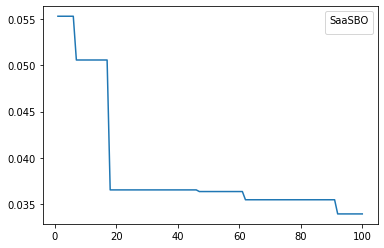

In [49]:
df_plot = df_training.query('bo_iteration>0')
import numpy as np
import matplotlib.pyplot as plt

x = df_plot['bo_iteration']
y = df_plot['loss'].cummin()

plt.plot(x, y)
plt.legend(title='SaaSBO')
plt.show()

number of GT edges: 196
number of GT edges: 196
number of GT edges: 196
number of GT edges: 196
number of GT edges: 196
number of GT edges: 196
number of GT edges: 196
number of GT edges: 196
number of GT edges: 196
number of GT edges: 196


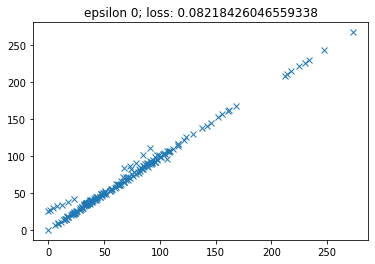

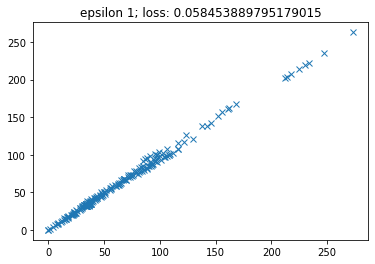

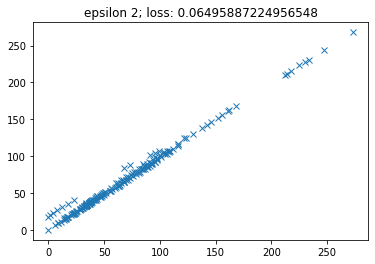

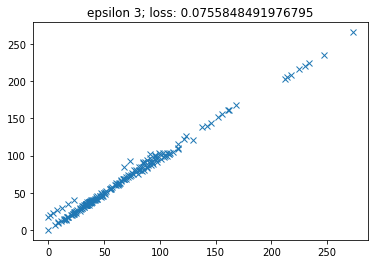

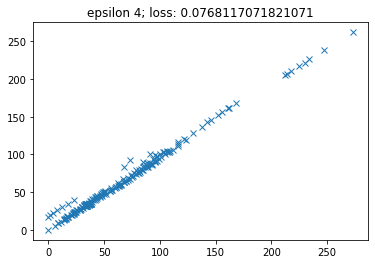

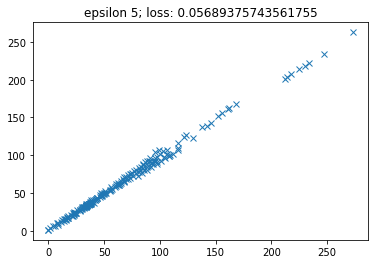

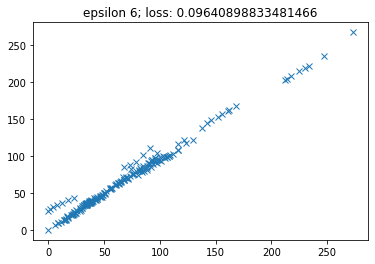

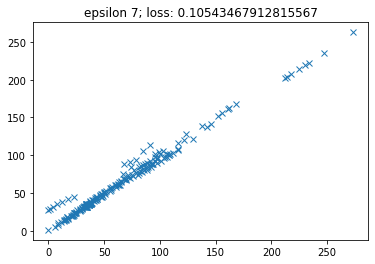

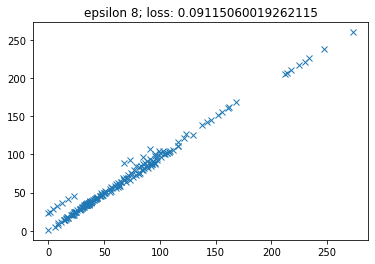

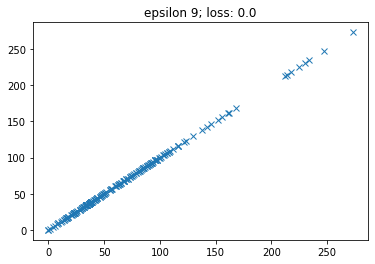

In [39]:
import matplotlib.pyplot as plt

for o1 in range(num_epsilon_iter):
    df1b = gt_edge_data.merge(edge_epsilon_all[o1], on=['edge_id'], how='left')
    curr_loss = compute_nrmse_counts_all_edges(gt_edge_data, edge_epsilon_all[o1])

    plt.figure()
    plt.plot(df1b.interval_nVehContrib_x, df1b.interval_nVehContrib_y, 'x') 
    plt.title(f'epsilon {o1}; loss: {curr_loss}')


In [24]:
sim_end_time

300